<a href="https://colab.research.google.com/github/RichardOrimolade/FirstRepo/blob/master/Copy_of_ee_api_colab_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Copyright 2019 Google LLC. { display-mode: "form" }
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="ee-notebook-buttons" align="left"><td>
<a target="_blank"  href="http://colab.research.google.com/github/google/earthengine-api/blob/master/python/examples/ipynb/ee-api-colab-setup.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a>
</td><td>
<a target="_blank"  href="https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/ee-api-colab-setup.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td></table>

03. Convolutional Neural Networks and Computer Vision with TensorFlow
Now we're going to get specific and see how a special kind of neural network, convolutional neural networks (CNNs) can be used for computer vision (detecting patterns in visual data).

A (typical) architecture of a convolutional neural network

Components of a convolutional neural network:

Hyperparameter/Layer type	What does it do?	Typical values
Input image(s)	Target images you'd like to discover patterns in	Whatever you can take a photo (or video) of
Input layer	Takes in target images and preprocesses them for further layers	input_shape = [batch_size, image_height, image_width, color_channels]
Convolution layer	Extracts/learns the most important features from target images	Multiple, can create with tf.keras.layers.ConvXD (X can be multiple values)
Hidden activation	Adds non-linearity to learned features (non-straight lines)	Usually ReLU (tf.keras.activations.relu)
Pooling layer	Reduces the dimensionality of learned image features	Average (tf.keras.layers.AvgPool2D) or Max (tf.keras.layers.MaxPool2D)
Fully connected layer	Further refines learned features from convolution layers	tf.keras.layers.Dense
Output layer	Takes learned features and outputs them in shape of target labels	output_shape = [number_of_classes] (e.g. 3 for pizza, steak or sushi)
Output activation	Adds non-linearities to output layer	tf.keras.activations.sigmoid (binary classification) or tf.keras.activations.softmax

1. Import and become one with the data

In [ ]:

import zipfile

# Download zip file of pizza_steak images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-09-20 12:09:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.126.128, 74.125.202.128, 74.125.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   240MB/s    in 0.4s    

2022-09-20 12:09:08 (240 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



In [ ]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (512, 512, 3)
Image shape: (512, 512, 3)


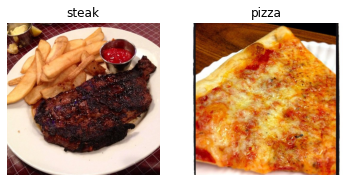

In [ ]:
# Visualize data (requires function 'view_random_image' above)
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("pizza_steak/train/", "steak")
plt.subplot(1, 2, 2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")

2. Preprocess the data (prepare it for a model)

In [ ]:
# Define training and test directory paths
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

In [ ]:
# Create train and test data generators and rescale the data 
# helps prepare our images to batches as well as transformations
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
# Turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               batch_size=32)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224, 224),
                                             class_mode='binary',
                                             batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
# Get a sample of the training data batch 
images, labels = train_data.next() # get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

In [ ]:
# Get the first two images
images[:2], images[0].shape

(array([[[[0.7372549 , 0.7490196 , 0.72156864],
          [0.75294125, 0.7607844 , 0.7411765 ],
          [0.7490196 , 0.7568628 , 0.74509805],
          ...,
          [0.10196079, 0.09411766, 0.1137255 ],
          [0.11764707, 0.10980393, 0.12156864],
          [0.08627451, 0.07843138, 0.08235294]],
 
         [[0.73333335, 0.74509805, 0.7176471 ],
          [0.75294125, 0.7607844 , 0.7411765 ],
          [0.75294125, 0.7607844 , 0.7490196 ],
          ...,
          [0.1254902 , 0.11764707, 0.12941177],
          [0.09019608, 0.08235294, 0.09411766],
          [0.10980393, 0.10196079, 0.10588236]],
 
         [[0.7254902 , 0.7372549 , 0.70980394],
          [0.7568628 , 0.76470596, 0.74509805],
          [0.7725491 , 0.7725491 , 0.76470596],
          ...,
          [0.08627451, 0.07058824, 0.07450981],
          [0.10196079, 0.09411766, 0.09803922],
          [0.14901961, 0.14117648, 0.14509805]],
 
         ...,
 
         [[0.7725491 , 0.7568628 , 0.74509805],
          [0.76862

In [ ]:
224, 224, 1

(224, 224, 1)

In [ ]:
# View the first batch of labels
# 0 for pizza 1 for steak
labels

array([1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

3.  Create a model (start with a baseline)

In [ ]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [ ]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_1 = Sequential([
  Conv2D(filters=10, 
         kernel_size=3, 
         strides=1,
         padding='valid',
         activation='relu', 
         input_shape=(224, 224, 3)), # input layer (specify input shape)
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  Flatten(),
  Dense(1, activation='sigmoid') # output layer (specify output shape)
])

In [ ]:
# Compile the model
model_1.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

4. Fit a modelOur model is compiled, time to fit it.

You'll notice two new parameters here:

steps_per_epoch - this is the number of batches a model will go through per epoch, in our case, we want our model to go through all batches so it's equal to the length of train_data (1500 images in batches of 32 = 1500/32 = ~47 steps)
validation_steps - same as above, except for the validation_data parameter (500 test images in batches of 32 = 500/32 = ~16 steps)

In [ ]:
# Check lengths of training and test data generators
len(train_data), len(test_data)

(47, 16)

In [ ]:
# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 117s 2s/step - loss: 0.9753 - accuracy: 0.6767 - val_loss: 0.4520 - val_accuracy: 0.7840
Epoch 2/5
47/47 [==============================] - 117s 2s/step - loss: 0.4018 - accuracy: 0.8280 - val_loss: 0.4179 - val_accuracy: 0.8160
Epoch 3/5
47/47 [==============================] - 117s 2s/step - loss: 0.2773 - accuracy: 0.8913 - val_loss: 0.4101 - val_accuracy: 0.8320
Epoch 4/5
47/47 [==============================] - 117s 2s/step - loss: 0.1439 - accuracy: 0.9587 - val_loss: 0.4093 - val_accuracy: 0.8260
Epoch 5/5
47/47 [==============================] - 116s 2s/step - loss: 0.0654 - accuracy: 0.9820 - val_loss: 0.5449 - val_accuracy: 0.7860


5. Evaluate the model

In [ ]:

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

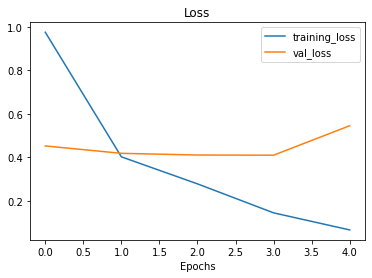

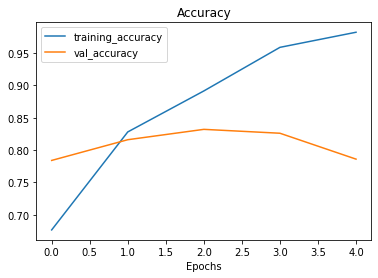

In [ ]:
# Check out the loss curves of model_4
plot_loss_curves(history_1)

Hmm, judging by our loss curves, it looks like our model is overfitting the training dataset.

In [ ]:
# Check out our model's architecture
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_2 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten (Flatten)           (None, 475240)            0         
                                                                 
 dense (Dense)               (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


6. Adjust the model parameters
Fitting a machine learning model comes in 3 steps:

Create a basline.
Beat the baseline by overfitting a larger model.
Reduce overfitting.
So far we've gone through steps 0 and 1.

And there are even a few more things we could try to further overfit our model:

Increase the number of convolutional layers.
Increase the number of convolutional filters.
Add another dense layer to the output of our flattened layer.
But what we'll do instead is focus on getting our model's training curves to better align with eachother, in other words, we'll take on step 2.

Why is reducing overfitting important?

When a model performs too well on training data and poorly on unseen data, it's not much use to us if we wanted to use it in the real world.

Say we were building a pizza vs. steak food classifier app, and our model performs very well on our training data but when users tried it out, they didn't get very good results on their own food images, is that a good experience?

Not really...

So for the next few models we build, we're going to adjust a number of parameters and inspect the training curves along the way.

Namely, we'll build 2 more models:

A ConvNet with max pooling
A ConvNet with max pooling and data augmentation
For the first model, we'll follow the modified basic CNN structure:

Input -> Conv layers + ReLU layers (non-linearities) + Max Pooling layers -> Fully connected (dense layer) as Output
Let's built it. It'll have the same structure as model_4 but with a MaxPool2D() layer after each convolutional layer.

In [ ]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.) 

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

Data augmentation is the process of altering our training data, leading to it having more diversity and in turn allowing our models to learn more generalizable patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar.

In [ ]:
# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=True) # Don't shuffle for demonstration purposes, usually a good thing to shuffle

# # Create non-augmented data batches
# print("Non-augmented training images:")
# train_data = train_datagen.flow_from_directory(train_dir,
#                                                target_size=(224, 224),
#                                                batch_size=32,
#                                                class_mode='binary',
#                                                shuffle=False) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

Augmented training images:
Found 1500 images belonging to 2 classes.
Unchanged test images:
Found 500 images belonging to 2 classes.


Better than talk about data augmentation, how about we see it?

(remember our motto? visualize, visualize, visualize...)

In [ ]:
32, 224, 224, 3

(32, 224, 224, 3)

In [ ]:
# Get data batch samples
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the same

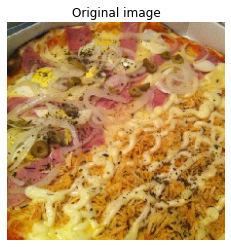

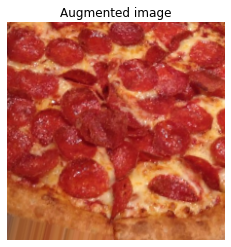

In [ ]:
# Show original image and augmented image
random_number = random.randint(0, 32) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

In [ ]:
# Create the model (same as model_5)
model_2 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_2 = model_2.fit(train_data_augmented, # changed to augmented training data
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 66s 1s/step - loss: 0.6492 - accuracy: 0.6047 - val_loss: 0.4672 - val_accuracy: 0.7900
Epoch 2/5
47/47 [==============================] - 66s 1s/step - loss: 0.5293 - accuracy: 0.7453 - val_loss: 0.4511 - val_accuracy: 0.7980
Epoch 3/5
47/47 [==============================] - 66s 1s/step - loss: 0.5163 - accuracy: 0.7553 - val_loss: 0.3905 - val_accuracy: 0.8280
Epoch 4/5
47/47 [==============================] - 66s 1s/step - loss: 0.4921 - accuracy: 0.7667 - val_loss: 0.3778 - val_accuracy: 0.8440
Epoch 5/5
47/47 [==============================] - 66s 1s/step - loss: 0.5049 - accuracy: 0.7593 - val_loss: 0.3695 - val_accuracy: 0.8300


7. Repeat until satisified
Since we've already beaten our baseline, there are a few things we could try to continue to improve our model:

Increase the number of model layers (e.g. add more convolutional layers).
Increase the number of filters in each convolutional layer (e.g. from 10 to 32, 64, or 128, these numbers aren't set in stone either, they are usually found through trial and error).
Train for longer (more epochs).
Finding an ideal learning rate.
Get more data (give the model more opportunities to learn).
Use transfer learning to leverage what another image model has learned and adjust it for our own use case.
Adjusting each of these settings (except for the last two) during model development is usually referred to as hyperparameter tuning.

Making a prediction with our trained model

In [ ]:
# Get the class names
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


--2022-09-20 13:22:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg’

03-steak.jpeg       100%[===================>]   1.89M  --.-KB/s    in 0.06s   

2022-09-20 13:22:29 (32.5 MB/s) - ‘03-steak.jpeg’ saved [1978213/1978213]



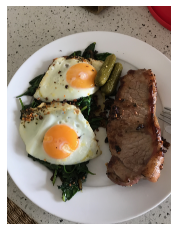

In [ ]:
 # View our example image
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg 
steak = mpimg.imread("03-steak.jpeg")
plt.imshow(steak)
plt.axis(False);

In [ ]:
# Check the shape of our image
steak.shape

(4032, 3024, 3)

In [ ]:
import tensorflow as tf
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

Now we've got a function to load our custom image, let's load it in.

In [ ]:
# Load in and preprocess our custom image
steak = load_and_prep_image("03-steak.jpeg")
steak

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.6377451 , 0.6220588 , 0.57892156],
        [0.6504902 , 0.63186276, 0.5897059 ],
        [0.63186276, 0.60833335, 0.5612745 ],
        ...,
        [0.52156866, 0.05098039, 0.09019608],
        [0.49509802, 0.04215686, 0.07058824],
        [0.52843136, 0.07745098, 0.10490196]],

       [[0.6617647 , 0.6460784 , 0.6107843 ],
        [0.6387255 , 0.6230392 , 0.57598037],
        [0.65588236, 0.63235295, 0.5852941 ],
        ...,
        [0.5352941 , 0.06862745, 0.09215686],
        [0.529902  , 0.05931373, 0.09460784],
        [0.5142157 , 0.05539216, 0.08676471]],

       [[0.6519608 , 0.6362745 , 0.5892157 ],
        [0.6392157 , 0.6137255 , 0.56764704],
        [0.65637255, 0.6269608 , 0.5828431 ],
        ...,
        [0.53137255, 0.06470589, 0.08039216],
        [0.527451  , 0.06862745, 0.1       ],
        [0.52254903, 0.05196078, 0.0872549 ]],

       ...,

       [[0.49313724, 0.42745098, 0.31029412],
        [0.05

In [ ]:
# Add an extra axis
print(f"Shape before new dimension: {steak.shape}")
steak = tf.expand_dims(steak, axis=0) # add an extra dimension at axis 0
#steak = steak[tf.newaxis, ...] # alternative to the above, '...' is short for 'every other dimension'
print(f"Shape after new dimension: {steak.shape}")
steak

Shape before new dimension: (224, 224, 3)
Shape after new dimension: (1, 224, 224, 3)


<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[0.6377451 , 0.6220588 , 0.57892156],
         [0.6504902 , 0.63186276, 0.5897059 ],
         [0.63186276, 0.60833335, 0.5612745 ],
         ...,
         [0.52156866, 0.05098039, 0.09019608],
         [0.49509802, 0.04215686, 0.07058824],
         [0.52843136, 0.07745098, 0.10490196]],

        [[0.6617647 , 0.6460784 , 0.6107843 ],
         [0.6387255 , 0.6230392 , 0.57598037],
         [0.65588236, 0.63235295, 0.5852941 ],
         ...,
         [0.5352941 , 0.06862745, 0.09215686],
         [0.529902  , 0.05931373, 0.09460784],
         [0.5142157 , 0.05539216, 0.08676471]],

        [[0.6519608 , 0.6362745 , 0.5892157 ],
         [0.6392157 , 0.6137255 , 0.56764704],
         [0.65637255, 0.6269608 , 0.5828431 ],
         ...,
         [0.53137255, 0.06470589, 0.08039216],
         [0.527451  , 0.06862745, 0.1       ],
         [0.52254903, 0.05196078, 0.0872549 ]],

        ...,

        [[0.49313724, 0.42745098, 

In [ ]:
# Make a prediction on custom image tensor
pred = model_2.predict(steak)
pred

array([[0.85547334]], dtype=float32)

Ahh, the predictions come out in prediction probability form. In other words, this means how likely the image is to be one class or another.

Since we're working with a binary classification problem, if the prediction probability is over 0.5, according to the model, the prediction is most likely to be the postive class (class 1).

And if the prediction probability is under 0.5, according to the model, the predicted class is most likely to be the negative class (class 0).

But saying positive and negative class doesn't make much sense when we're working with pizza 🍕 and steak 🥩...

So let's write a little function to convert predictions into their class names and then plot the target image.

In [ ]:
# Remind ourselves of our class names
class_names

array(['pizza', 'steak'], dtype='<U5')

In [ ]:
# We can index the predicted class by rounding the prediction probability
pred_class = class_names[int(tf.round(pred)[0][0])]
pred_class

'steak'

In [ ]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

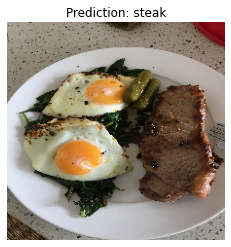

In [ ]:
# Test our model on a custom image
pred_and_plot(model_2, "03-steak.jpeg", class_names)